In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Patent Dataset.xlsx")

In [3]:
# aadharNumbers , title , abstract , abstract_bert_embeddings , patent_status=3,created_at , modified_at
from pymongo import MongoClient

cluster = MongoClient("localhost", 27017)
db = cluster["Patent"]
collection_patents = db["Patents"]
collection_transactions = db["Transactions"]

In [8]:
print(f"Total Number of Patents in dataset : {len(df)}")

Total Number of Patents in dataset : 3522


In [142]:
import datetime
import pickle
from sentence_transformers import SentenceTransformer

# tokenizer = BertTokenizer.from_pretrained("./model/")
# model = BertModel.from_pretrained("./model/")
model = SentenceTransformer("./sentence_models/t5")

for index , patent in df.iterrows():
    
    if index < 231:
        continue

    if index >= 1000:
        break

    aadharNumbers = ["123456781234"]  
    title = patent["patent_title"]
    abstract = patent['patent_abstract']

    # Abstract Embeddings
    words = abstract.split(" ")
    abstract = ' '.join(words)
    
    # target_input_ids = tokenizer.encode(abstract, add_special_tokens=True)
    # target_input_ids = torch.tensor(target_input_ids).unsqueeze(0)

    # # Get contextualized embeddings for the target description
    # with torch.no_grad():
    #     target_outputs = model(target_input_ids)
    # target_embeddings = target_outputs.last_hidden_state.mean(dim=1)

    target_embeddings = model.encode(abstract)
    serialized_target_embeddings = pickle.dumps(target_embeddings)

    collection_patents.insert_one({'title' : title , 'aadharNumbers' : aadharNumbers , 'abstract' : abstract , 'abstract_embeddings' : serialized_target_embeddings , 'patent_status' : 3 ,'created_at' : datetime.datetime.utcnow() , 'modified_at' : datetime.datetime.utcnow()})

    if index%100 == 0:
        print(f"{index} Patents Uploaded")

300 Patents Uploaded
400 Patents Uploaded
500 Patents Uploaded
600 Patents Uploaded
700 Patents Uploaded
800 Patents Uploaded
900 Patents Uploaded


In [160]:
embeddings = []

for patent in collection_patents.find({}).limit(100):
    embed = pickle.loads(patent["abstract_embeddings"])
    embeddings.append(embed)

In [161]:
# Divide the embedding vector by its length to make it unit vector
for i in range(len(embeddings)):
    distance = np.sqrt((embeddings[i] * embeddings[i]).sum())
    embeddings[i] = (embeddings[i] / distance)

In [162]:
# Using dot product to find the difference between two embeddings. Alternative to Cosine Similarity
score = np.zeros((len(embeddings) , len(embeddings)) , dtype=np.float64)

for idx1 in range(len(embeddings)):
    for idx2 in range(idx1+1 , len(embeddings)):
        score[idx1 , idx2] = embeddings[idx1].dot(embeddings[idx2])

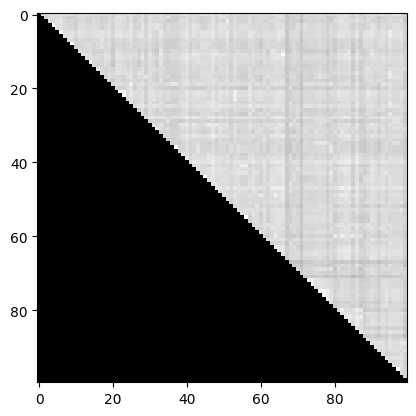

In [163]:
import matplotlib.pyplot as plt

plt.imshow(score , cmap="gray")
plt.show()

In [176]:
import matplotlib.pyplot as plt

for i in range(len(score)):
    count = 0
    for j in range(len(score)):
            
        if i == j:
            continue

        if score[i , j] >= 0.95:
            count += 1
    
    if count > 0:
        print(f"Similar {i}th patent count : {count}")

Similar 3th patent count : 1
Similar 5th patent count : 1
Similar 8th patent count : 1
Similar 11th patent count : 1
Similar 21th patent count : 2
Similar 22th patent count : 1
Similar 36th patent count : 1
Similar 44th patent count : 1
Similar 55th patent count : 1
Similar 73th patent count : 1
Similar 75th patent count : 3
Similar 76th patent count : 1
Similar 96th patent count : 1


In [180]:
df.iloc[1001].patent_abstract

'An image processing system, which operates on an input image data stream consisting of successive multi-level values, effecting a plurality of respectively different types of image data processing in accordance with a plurality of different categories of the input image data, utilizes a neural network to assign each datum to a specific category, with resultant output signals from the neural network being used to select the appropriate type of image data processing for that datum.'